In [ ]:
%pip install -q -r requirements.txt

In [15]:
import matplotlib.pyplot as plt
import serial
import numpy as np
from numpy.random import randn
from numpy import dot, linalg, eye, array
import matplotlib.animation as animation
from time import time

## Kalman Filters

Following is a simplified, and summerized version of the inner workings of the Kalman Filter. All the information is based on the resources attached in the references section. Focus will be on the intuitive understanding behind the Kalman Filters, and the mathematical derivations, and elaborations will be referenced with exact page numbers on the source materials.

## 1. State and Sensor data representation  <a class="anchor" id="c1"></a>

### Representation of Sensor Data and State Parameters as Probability Distributions

In the context of Kalman filtering and probabilistic robotics, every sensor data and state parameter is represented as a probability distribution. This approach allows us to quantify the uncertainty associated with our measurements and state estimates and further use this uncertainty to make sound adjustments to our state when fusing other sensor data.

Sensor data, such as measurements from a GPS, LIDAR, or camera, is inherently noisy. Instead of treating these measurements as exact values, we represent them as probability distributions. This probabilistic representation captures the uncertainty and variability in the sensor data.

For example, if a anchor sensor provides a position measurement of tag, we can represent this measurement as a Gaussian distribution with a mean (the measured position) and a variance (the measurement noise). This distribution reflects our belief about the true position given the noisy measurement.

Following is the simple example of tag's location measurement by anchor sensor after 100 measurements. Here the mean is set at 10m and variance is set at 1m, meaning the most likely correct position of tag is 10m's from the anchor sensor with uncertainty of 1m variance.



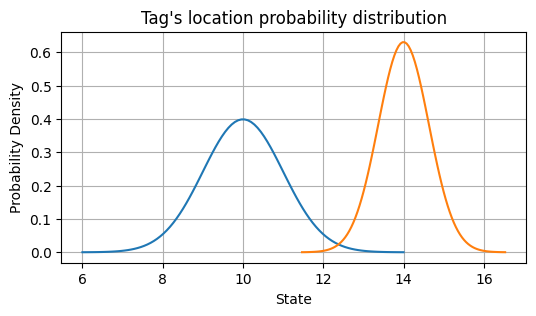

In [29]:
def plot_gaussian_distribution(mean, variance, title="Gaussian Distribution"):
    """Helper function to plot Gaussian distributions"""
    x = np.linspace(mean - 4*np.sqrt(variance), mean + 4*np.sqrt(variance), 100)
    y = 1/np.sqrt(2*np.pi*variance) * np.exp(-(x-mean)**2/(2*variance))
    
    plt.figure(figsize=(6, 3))
    plt.plot(x, y, label="Prior 1")
    plt.title(title)
    plt.xlabel('State')
    plt.ylabel('Probability Density')
    plt.grid(True)
    return plt


mean, variance = 10, 1
plot_gaussian_distribution(mean, variance, "Tag's location probability distribution")
    
mean, variance = 14, 0.4
x = np.linspace(mean - 4*np.sqrt(variance), mean + 4*np.sqrt(variance), 100)
y = 1/np.sqrt(2*np.pi*variance) * np.exp(-(x-mean)**2/(2*variance))
plt.plot(x, y, label="Prior 2") 
plt.show()




# Gaussian based Filters

Kalman filters are one of most commonly known Gaussian based Filters. All these filters have underlying assumption that any state of the system, also called belief system in books, can be resprented as a multivariate Gaussian distribution. This Gaussian distribution is commonly used for following assumptions and advantages it provides:

#### Central limit theorem

There's an underlying assumption in these type of filters that as our sample size, measurements, and state change continues, the distribution of our state will converge to a Gaussian distribution. This is due to the central limit theorem, which states that the sum of a large number of independent random variables will converge to a Gaussian distribution.

#### Unimodality of Gaussian distribution

When it comes to predicting our next state, positoin of tag for example, preferably we would like to have a single most likely position with a certain amount of uncertainty. Gaussian distribution provides this unimodal property, meaning it has a single peak, which represents the most likely value of the state (mean), and the uncertainty is captured by the variance of the distribution. Having equally likely numerous states would make it difficult to make predictions and decisions.

#### Parameterization of Gaussian distribution

Gaussian distributions offer a simple parameterization with only two parameters: the mean and the covariance. This makes it easy to represent and manipulate the distribution mathematically. For example, we can easily compute the sum, and product of two Gaussian distributions, which are essential operations in Kalman filtering.

#### Linear transformations of Gaussian distribution

Assuming we know the current probability density distribution of our state, it makes sense that we need to know the posterior probaility density distribution after our state of the system undergoes change. This way, we will able to make sound predictions while keeping track of our uncertainty of our state. Gaussian distributions satisfy this requirement well as the linear transformations of Gaussian distributions are also Gaussian. This property is essential for the Kalman filter, which involves linear transformations of the state and sensor models.

We can see in the following illustration how linear transformation of a given Gaussian distribution results in another Gaussian distribution where:

Given a multivariate Gaussian distribution $N(μ, Σ)$ with mean $μ$ and covariance $Σ$, the linear transformation: 

$y = Ax + b$

Results in another multivariate Gaussian distribution:

$N(Aμ + b, AΣA^T)$ where mean is $Aμ + b$ and covariance is $AΣA^T$.

<img src="images/linear_trans.png" alt="bn" width="800"/>

# Coming back to Kalman Filters

Simply put, Kalman filters, under the hood, are a method of making educated guess about the next state of the system based on different probability distributions regarding the current state.

Let's take following simple example to illustrate this. Given two Gaussian distributions regarding the tag's location, what should the resulting sound prediction regarding the correct location of the tag be?

Distribution 1: $N(μ_1, Σ_1)$, where $μ_1 = 10m$, $Σ_1 = 1m$

Distribution 2: $N(μ_2, Σ_2)$, where $μ_2 = 14m$, $Σ_2 = 0.4m$




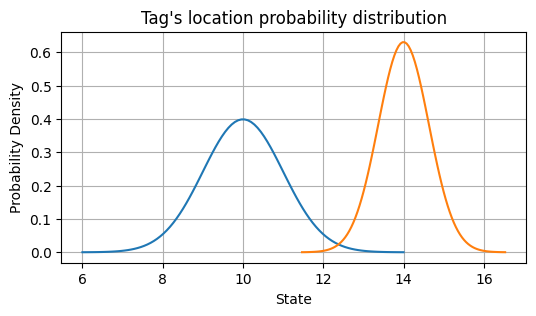

In [21]:
mean, variance = 10, 1
plot_gaussian_distribution(mean, variance, "Tag's location probability distribution")
    
mean, variance = 14, 0.4
x = np.linspace(mean - 4*np.sqrt(variance), mean + 4*np.sqrt(variance), 100)
y = 1/np.sqrt(2*np.pi*variance) * np.exp(-(x-mean)**2/(2*variance))
plt.plot(x, y)
plt.show()

Natural sound guess is to assume that most likely the tag is between $10m$ and $14m$ from the anchor sensor. We need to represent this guess as a Gaussian distribution, where the mean rests between $10m$ and $14m$ and the variance is less than the variance of the two distributions. Simple filters like **Complemetary filters** would assign hand-written weights to these distributions and combine them. However, Kalman filters provide a more sophisticated way of combining these distributions by taking into account the uncertainty of the measurements and the state estimates.


#### Kalman Gain

The adjusting weight in Kalman Filters are called **Kalman Gain**, where given simga $σ_1^2$ and $σ_2^2$ of two Gaussian distributions, we would like to assign weights $W_1$ and $W_2$ such that:

$$
\mu_{post}=W_1 \mu_1 + W_2 \mu_2
$$

$$
W_1 + W_2 = 1
$$

Here it is helpful to imagine that Distribution 1 is our predicted localization of the tag we found based on our acceleration and speed, and Disritbution 2 is the measurement distribution from the anchor sensor. We would like to assign weights to these distributions such that the resulting distribution is the most likely correct position of the tag.

Substituting the $W_2$ as $K$, called **Kalman Gain** in the above equations gives us:

$$
\mu_{post}=(1 - K) \mu_1 + K \mu_2
$$

$$
\mu_{post}=\mu_1 + K(\mu_2 - \mu_1)
$$

$$
K=\frac{\sigma_1^2}{\sigma_1^2+\sigma_2^2}
$$

Basically, Kalman gain is the ratio of our prediction uncertainty, and measurement uncertainty. If our prediction has really high uncertainty, we would get $K$ close to 1, meaning that we will update our mean value closer to the measurement mean, and vice versa. In simple words, we lean towards trusting the distribution that has less uncertainty.

Following is simple illustration of above equation regarding tag
s location. $(\mu_2 - \mu_1)$ is often called **innovation/residual** in books, and it is simply distance between our predicted location of the tag and the measurement location of the tag, and our Kalman gain is scaler of this delta distance.

<img src="images/residual.png" alt="bn" width="800"/>

In the following depiction, we can see that resulting distribution is a Gaussian distribution with mean between $10m$ and $14m$ and variance less than the variance of the two distributions. Variance of the resulting distribution is calculated as:

$$
Variance_{post} = Variance_{prior} - Kalman Gain * Variance_{prior}
$$

To summarize, Kalman is about finding product of Gaussian distributions, and in doing so we find new appropriate mean and variance for the resulting Gaussian distribution. This is done by finding the Kalman gain. 

>(The detailed mathematical derivations can be found on page 45 of Probabilistic Robotics book.)

#### Simple overlapping of Gaussian distributions can be depicted as follows:

- Blue is posterior distribution
- Elipse shows the variance of the distribution



<img src="images/dist_overlap.png" alt="bn" width="800"/>


Following is the depiction of the resulting Gaussian distribution from our previous example, we get posterior distribution like following:

Posterior mean:  12.857142857142858
Posterior variance:  0.2857142857142857


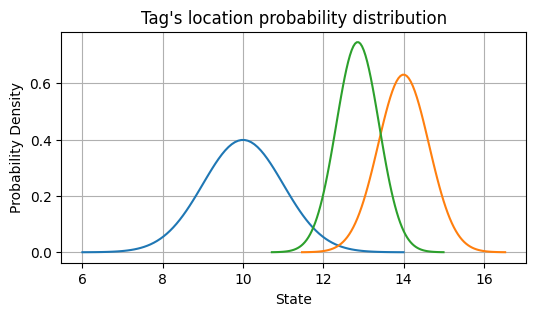

In [40]:
mean1, variance1 = 10, 1
plot_gaussian_distribution(mean1, variance1, "Tag's location probability distribution")
    
mean2, variance2 = 14, 0.4
x = np.linspace(mean2 - 4*np.sqrt(variance2), mean2 + 4*np.sqrt(variance2), 100)
y = 1/np.sqrt(2*np.pi*variance2) * np.exp(-(x-mean2)**2/(2*variance2))
plt.plot(x, y)

# Plot posterior distribution
K = variance1 / (variance1 + variance2)
mean3 = mean1 + K * (mean2 - mean1)
variance3 = (1 - K) * variance1

print("Posterior mean: ", mean3)
print("Posterior variance: ", variance3)

x = np.linspace(mean3 - 4*np.sqrt(variance3), mean3 + 4*np.sqrt(variance3), 100)
y = 1/np.sqrt(2*np.pi*variance3) * np.exp(-(x-mean3)**2/(2*variance3))
plt.plot(x, y)

plt.show()


## Designing Linear Kalman Filters

Kalman is recurisive state estimation where the previous state distribution is enough for use to predict the next state in conjunction with control input and sensor measurements. Main idea here is that linear transformation of Gaussian distribution is also Gaussian distribution, and we can use this property to predict the next state of the system.

#### Markov Chain and Complete State

A state of the system is considered Complete if it encompasses all the all previous state information, control input information, and measurement informations to predict the next state. This is often called Markov Chain property, where current state only depends on the previous state.

#### Control Input and Measurement input

Seperation between control input and measurement input is essential in Kalman filters. Control input is cause of change in our internal state such as acceleration, speed, etc. Measurement input is state we obtain from sensors such as GPS, LIDAR, etc. Commong notations are:

$$
x_t = \text{Our state at time t}
$$
$$
u_t = \text{Control input at time t}
$$
$$
z_t = \text{Measurement at time t}
$$

It is convenient to image 1-D example where $x_t$ is location and speed of out tag at time $t$, and $u_t$ is acceleration of the tag at time $t$, and $z_t$ is the location of the tag we obtain from the anchor sensor at time $t$.


#### State Transition Equation

Based on above example, since we are interested in tracking the localization, we would like to know the location of our tag and it's speed at next time. We can represent this as a complete state as follows:

$$
x_t = A_t x_{t-1} + B_t u_t + \epsilon_t
$$

Where $A_t$ is the state transition matrix, $B_t$ is the control input matrix, and $\epsilon_t$ is the process noise. This equation is called **State Transition Equation**.

For instance we represent the state transition matrix as follows:

$$
x = \begin{bmatrix} x \\ \dot{x} \end{bmatrix} \text{, where } {\dot{ x }} \text{ is speed}
$$

$$
A_t = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}, \text{since } x_{t} = x_{t-1} + \dot{x} \Delta t \text{, and } \dot{x}_t = \dot{x}_{t-1}
$$

$$
u = \begin{bmatrix} \ddot{x} \end{bmatrix}, \text{where } \ddot{x} \text{ is acceleration}
$$

$$
B_t = \begin{bmatrix} \frac{\Delta t^2}{2} \\ \Delta t \end{bmatrix}, \text{since } x_{t} = x_{t-1} + \dot{x} \Delta t + \frac{1}{2} a \Delta t^2 \text{, and } \dot{x}_t = \dot{x}_{t-1} + a \Delta t
$$


**$\epsilon_t$** represents the white noise with mean 0 and covariance $R$ and we add this to account for the noise in control input: acceleration IMU sensor in our example. This noise is the crucial part in designing our filter. More on it bit later.




#### Measurement Equation

Current state of the system is representation of the internal knowledge we posses. We need to be able to translate this knowledge represented as distribution into the measurment distribution we want to obtain. This process is necessary as we need to compare our internal state distribution with the measurement distribution to make sound predictions, and internal state distribution is not always represented in same form as the measurement distribution, so we translate the distribution. For instance, our state contains distribution of location and speed of the tag while measurement contains only the location distribution of the tag, so direct comparison.
This is done by the measurement equation:

$$
z_t = C_t x_t + \delta_t
$$

Where $C_t$ is the measurement matrix, and $\delta_t$ is also a white noise added to account for measurment sensor noise with covariance **$Q_t$**, more on this later. This equation is called **Measurement Equation**. Our current example contains location and speed of the tag in 1-D space, and we would like to just get the location of tag from the anchor sensor. We can represent simply like following:

$$
z_t = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix} + \delta_t
$$

$$
C_t = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$



#### Working with Gaussian Distributions

Since we are working with Gaussian Distributions, we can represent our state, and uncertainty using mean $\mu$ and covariance $\Sigma$. Our state transition equation and measurement equation can be represented as follows:


<img src="images/kalman_algo.png" alt="bn" width="800"/>

### Breakdown of Kalman Filter Algorithm

##### Line 2 - 3: Predicting the next state

We can see that we need our state information represented as multivariate Gaussian distribution with mean $\mu_{t-1}$, covariance $\Sigma_{t-1}$, control input $u_t$, and measurement from sensor at time $z_t$. Line 2 describes what our predicted posterior distribution have as mean $\bar{\mu_t}$ after going through linear transformation of our state transition equation. Line 3 describes what our predicted posterior distribution have as covariance $\bar{\Sigma_t}$ after going through linear transformation of our state transition equation and we add uncertainty of our Control sensor data using $R_t$ noise. This part is called **Prediction Step**.

##### Line 4: Kalman Gain

In line 4, we are finding Kalman Gain at time $t$, $K_t$. In previos example, we were able to find it using $K=\frac{\sigma_1^2}{\sigma_1^2+\sigma_2^2}$. In this case, it is exact same thing, but in matrix form. Since division by matrix doesn't make sense, we use inverse matrix of the denominator. Our previous $\sigma_2$ becomes $Q_t$ in this case, and so on.


##### Line 5 - 6: Update step

In line 5, we can see that we are doing the exact same things we did previosly in our simple example. We are finding the innovation/residual by $z_t - C_t\bar{\mu_t}$ and scaling it using our Kalman Gain to adjust the posterior distribution mean $\mu$. Same goes for Line 6.

##### End

In the end, our updated state information is represented as $\mu_t$ and $\Sigma_t$ through fusion of our own prediction and correction from the measurement.



#### More on $Q_t$ and $R_t$ noise covariances

Some materials oftentimes swap these notations but let's stick to the following:
- $Q_t$ is the covariance of the measurement noise, and it is the uncertainty of the sensor measurement. It is the noise in the measurement sensor.
- $R_t$ is the covariance of the process noise, and it is the uncertainty of the control input. It is the noise in the control sensor.


##### $Q_t$ measurement noise

Measurement noise covariance is simply the uncertainty of the sensor measurement. For instance, if we are using UWB sensor to measure the location of the tag, we can assume that the UWB sensor has a certain amount of uncertainty in its measurement. This uncertainty is represented as the covariance of the measurement noise. We use this uncertainty to adjust our Kalman Gain to decide which one to lean towards, our prediction or the measurement.

In our simple example of tag, it can be 1x1 matrix where $Q_t = \begin{bmatrix} \sigma^2 \end{bmatrix}$, where $\sigma$ is the standard deviation of the sensor measurement noise. It can be fixed value, or even can be update during the state transitions. It is entirely up to the design choice and sensor characteristics.


##### $R_t$ Process covariance noise

>Different methods to create process noise covariance is covered in the page 243 of the Kalman and Bayesian Filters in Python book.

According to the book, process covariance noise is one of most crucial steps in designing Kalman Filters. It should model uncertainty in our control input affects the uncertainty of our state. For instance, if we are using IMU sensor to measure the acceleration of the tag, we can assume that the IMU sensor has a certain amount of uncertainty in its measurement. This uncertainty is represented as the covariance of the white Gaussian process noise, and should reflect how acceleration uncertainty affects position, and velocity uncertainty.

Since, as we previosly saw on the Kalman Filter algorithm, the control input is transformed through control input matrix $B_t$ to be integrated into our state, so we need to pass this uncertainty through this transformation. This is done by the following linear transformation of Gaussian distribution's covariance:

$$
R_t = B_t \sigma^2 B_t^T
$$






#### Initialization of the Kalman Filter

When designing Kalman filters, we need to design the initial process covariances, noise covariances, and initial state mean. This process mostly dependent on the specifics of the application.

##### Initial state mean and covariance

If we were tracking tag's location at 10 meters with variances of 1 meter, and speed of 0 m/s with variance of 0.1 m/s, we can represent our initial state mean and covariance as follows:

$$
\mu_0 = \begin{bmatrix} 10 \\ 0 \end{bmatrix}, \Sigma_0 = \begin{bmatrix} 1 & 0 \\ 0 & 0.1 \end{bmatrix}
$$

Over time, the covariance of the state will change without intervention as we make predictions and update our state based on the sensor measurements. This is one of the benefit of Kalman Filters.

##### Measurement and Process noise covariance

Since these noises are directly tied to the nature of the sensors, it needs to be carefully calibrated and adjusted for the Filter to produce good results.


## Non-linear models

Kalman filters work well because linear transformation of Gaussian distribution is also Gaussian distribution. However, in real world, most of the systems are non-linear. That means our state transformation, measurement transformation, and process noise transformation can be non-linear. This non-linearity makes the resulting distribution from Gaussian unknown, reducing our ability to make sound predictions.

#### Non-linear models example

For instance, if our state transition requires transformations that involve $sin$, $cos$, $tan$, and square root etc..., these are non-linear transformations. A tag that is moving in a complex path involving rotation while accelerating, and decelerating, would require non-linear transformations to predict the next state. 

Following is an example of resulting distribution from non-linear transformation of Gaussian distribution. We can see the resulting gray distribution is not Gaussian, and it is multimodal, making it difficult to make sound predictions. Solid line depicting Gaussian is derived using Monte-Carlo estimation.

>Ignore the EKF, Taylor part for now

<img src="images/non_lin.png" alt="non-lin" width="800"/>

## Extended Kalman Filters

In non-linear system, our state and measurement function will be given as:

$$
x_t = g(x_{t-1}, u_t) + \epsilon_t
$$

$$
z_t = h(x_t) + \delta_t
$$

Where $g$ and $h$ are non-linear functions, and $\epsilon_t$ and $\delta_t$ are the process and measurement noise.


To deal with non-linear models, we can use Extended Kalman Filters. Extended Kalman Filters are simply an extension of the Kalman Filter to non-linear models. The main idea is to linearize the non-linear transformation function $g$ and $h$. Book mentions that there are number of ways to linearize the non-linear functions, but the most common way is to use the first order Taylor expansion by selecting the **mean $\mu$ as the reference point**. 



$$
\begin{aligned}
g\left(u_t, x_{t-1}\right) & \approx g\left(u_t, \mu_{t-1}\right)+\underbrace{g^{\prime}\left(u_t, \mu_{t-1}\right)}_{=: G_t}\left(x_{t-1}-\mu_{t-1}\right) \\
& =g\left(u_t, \mu_{t-1}\right)+G_t\left(x_{t-1}-\mu_{t-1}\right)
\end{aligned}
$$

Here we are approximating non-linear $g$ function using First order Taylor expansion. $G_t$ is the Jacobian matrix of the function $g$ evaluated at the mean $\mu_{t-1}$ which makes it our **Transformation matrix**. $G_t$ is derived using partial derivative of the function $g$ with respect to the state $x$ evaluated at the mean $\mu_{t-1}$.

$$
\begin{aligned}
h\left(x_t\right) & \approx h(\bar{\mu_t})+\underbrace{h^{\prime}(\bar{\mu_t})}_{=: H_t}\left(x_{t}-\bar{\mu_{t}}\right) \\
& =g\left(u_t, \mu_{t-1}\right)+H_t\left(x_{t}-\bar{\mu_{t}}\right)
\end{aligned}
$$

Here we are using predicted mean $\bar{\mu_t}$ from our predict step. Similarily, $H_t$ is also a Jacobian matrix of the function $h$ evaluated at the predicted mean $\bar{\mu_t}$ which makes it our **Measurement matrix**. $H_t$ is derived using partial derivative of the function $h$ with respect to the predicted state $\bar{x}$.

As a result our Extended Kalman Filter algorithm will look like following:

<img src="images/ekf.png" alt="non-lin" width="800"/>

### Breakdown of Extended Kalman Filter Algorithm

We can see that it's almost identical to the Kalman Filter algorithm, but we are using the linearized transformation matrices $G_t$ and $H_t$ to make predictions and updates.

##### Line 2 - 3: Predicting the next state

In line 2, we can see that we are passing our control input and previous mean at time $t-1$ through the non-linear function $g$ linearized using First order Taylor expansion to get our predicted mean $\bar{\mu_t}$. In line 3, we are passing our previous coveraince and process noise through the linearized transformation of our $g$ using the $G_t$ to get our predicted covariance $\bar{\Sigma_t}$.

#### Line 4: Kalman Gain

In line 4, similar to Kalman Filter, we are transforming our predicted covariance into the measurement covariance using linearized version of our non-linear $h$ function to find the Kalman Gain.

#### Line 5 - 6: Update step

In line 5, we are finding the innovation/residual by $z_t - h(\bar{\mu_t})$ and scaling it using our Kalman Gain to adjust the posterior distribution mean $\mu$. Same goes for Line 6.


Following is helpful comparison of differences between Kalman and Extended Kalman Filters that summarizes what we have just discussed:

> In the following illustration Q stands for process noise covariance, and R stands for measurement noise covariance, contrary to how we denoted it previously. This is just due to the source material's notation.

<img src="images/kf-to-ekf.png" alt="non-lin" width="800"/>


### Finding Q and R noise covariances

In the previous step, we didn't fully discuss how to find the $R$ - the process noise covariance and $Q$ the measurement noise covariances.

#### Finding $Q$ - Process noise covariance

In normal Kalman filter, we found Process noise covariance by transforming the uncertainty of the control input through the control input matrix $B_t$. In Extended Kalman Filter, don't directly have control input matrix $B_t$, so we need to derive this $B_t$ from our non-linear function $g$. Since we are interested in how our non-linear function transforms and integrates the control input $u_t$ 
into our state, we do the following:

$$
\mathbf{B}=\frac{\partial f\left(\mathrm{x}_t, \mathrm{u}_t\right)}{\partial \mathbf{u}}
$$

$$
Q=\mathbf{B} \sigma^2 \mathbf{B}^{\top}
$$

This time, we take derivate of our function with respect to the control input $u$ to get our $B$ matrix. Using the same method we used in Linear Kalman, we will use covariance of the control input $\sigma^2$ to find our $Q$ noise covariance.


#### Finding $R$ - Measurement noise covariance

Here we don't need to do anything different from the Kalman Filter. We need to use well calibrated measurement sensor noise covariance.


#### Linear approximation depiction

<img src="images/ekf-linearize.png" alt="non-lin" width="800"/>

## Unscented Kalman Filters

Extended Kalman Filters are widely used in practice, but they have some limitations. The main limitation is that the linearization of the non-linear functions can introduce errors, especially if our mean is set on the highly non-linear part of the function. This can lead to poor performance of the filter. Unscented Kalman Filters are an alternative to Extended Kalman Filters that aim to address this limitation.

Following is the example depiction of how EKF can introduce errors while Unscented Kalman Filters perform better. The solid line represents the true approximated Gaussian distribution of the resulting distribution using Monte-Carlo approximation. We can see that EKF Gaussian approximation is not as accurate as the true distribution, while UKF is much closer to the true distribution.

<img src="images/ukf-ekf.png" alt="non-lin" width="800"/>


### Sigma Points in Unscented Kalman Filters

> Side note: According to the book, Unscented just means "not stinky" as in the algorithm doesn't stink, and is actually good by the author.

Given our current Gaussian distribution of our state, we select the points around the mean called **Sigma Points**. These Sigma Points are selected in such a way that they capture the mean and the covariance of the distribution. Then we pass those Sigma Points through our non-linear function to get the result, from which we compute the new distribution. Kind of like mini scale Monte-Carlo approximation.

<img src="images/sigma_projection.png" alt="non-lin" width="800"/>

We need to select the points in such a way that they capture the mean and the covariance of the distribution of our current distribution, so can track how the distribution changes through the non-linear function. The sigma points are selected deterministically aroundthe mean of our current distribution, and additional two points on both sides of the mean. The number of sigma points for $n$ dimensional Gaussian would be $2n+1$.


$$
\begin{aligned}
& \mathcal{X}^{[0]}=\mu \\
& \mathcal{X}^{[i]}=\mu+(\sqrt{(n+\lambda) \Sigma})_i \quad \text { for } i=1, \ldots, n \\
& \mathcal{X}^{[i]}=\mu-(\sqrt{(n+\lambda) \Sigma})_{i-n} \quad \text { for } i=n+1, \ldots, 2 n
\end{aligned}
$$

Here $λ = α^2(n+κ)−n$, with $α$ and $κ$ being scaling parameters that determines how spread the points are from the mean. The scaling parameters are usually set to hand-written values.

> More on how to select Sigma Points can be found on page 65 of Probabilistic Robotics book.




Each simga point has two weights associated with it, $w_m$ and $w_c$. These weights are used to compute the mean and covariance of the resulting distribution. The weights are set as follows:

$$
\begin{aligned}
& w_m^{[0]}=\frac{\lambda}{n+\lambda} \\
& w_c^{[0]}=\frac{\lambda}{n+\lambda}+\left(1-\alpha^2+\beta\right)
\end{aligned}
$$


$$
w_m^{[i]}=w_c^{[i]}=\frac{1}{2(n+\lambda)} \quad \text { for } i=1, \ldots, 2 n
$$

After we pass these points through our non-linear $g$ function:


$$
y^{[i]}=g\left(\mathcal{X}^{[\vec{i}]}\right)
$$

The resulting mean $\mu^{\prime}$ and covariance $\Sigma^{\prime}$ of the resulting distribution can be calculated as follows:

$$
\begin{aligned}
& \mu^{\prime}=\sum_{i=0}^{2 n} w_m^{[i]} y^{[i]} \\
& \Sigma^{\prime}=\sum_{i=0}^{2 n} w_c^{[i]}\left(y^{[i]}-\mu^{\prime}\right)\left(y^{[i]}-\mu^{\prime}\right)^T
\end{aligned}
$$


### Unscented Kalman Filter Algorithm

Following is the algorithm for the Unscented Kalman Filter.

> Detailed breakdown can be found on page 65 of Probabilistic Robotics book.
> Detailed breakdown can also be found on page 349 of Kalman and Bayesian Filters in Python book.

<img src="images/ukf-algo.png" alt="non-lin" width="800"/>

<img src="images/kf-ukf.png" alt="non-lin" width="800"/>